In [1]:
%matplotlib inline
import pandas as pd
import statsmodels.api as sm
import numpy as np

/Users/mrefermat/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
import seaborn as sns
import pylab
sns.set(font_scale=3)
pylab.rcParams['figure.figsize'] = (24, 18)

In [3]:
import quandl as q
token="Us3wFmXGgAj_1cUtHAAR"

In [4]:
sp=q.get("MULTPL/SP500_REAL_PRICE_MONTH", authtoken=token).Value

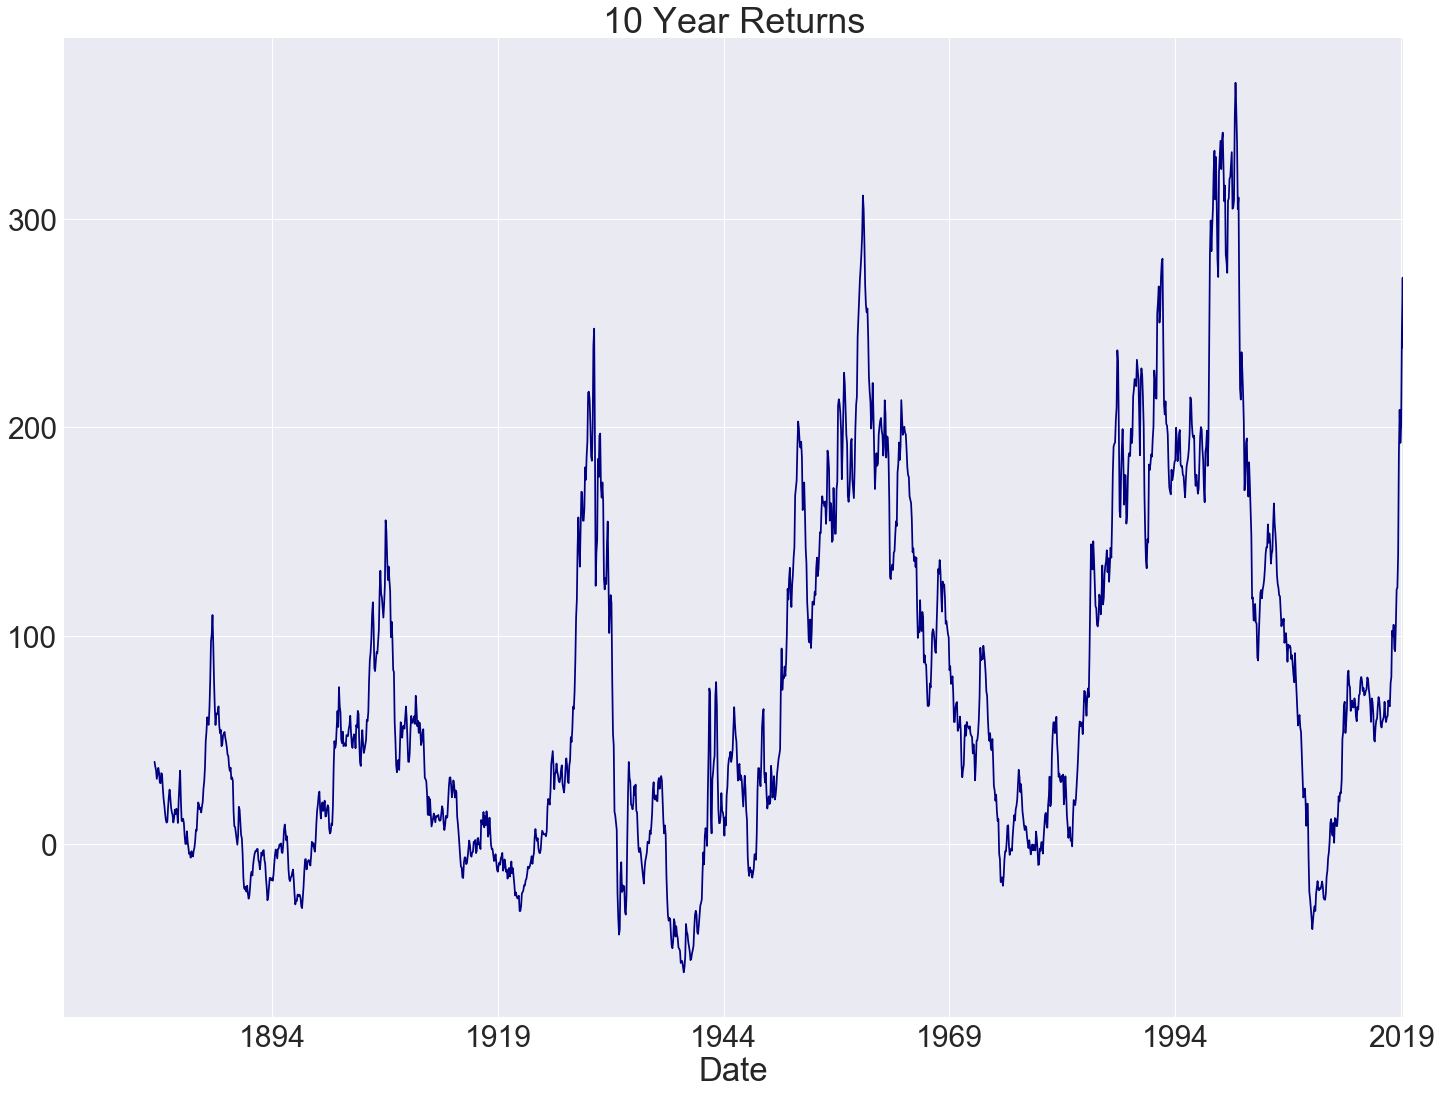

In [5]:
(sp.pct_change(120)*100).plot(colormap='jet',title='10 Year Returns')

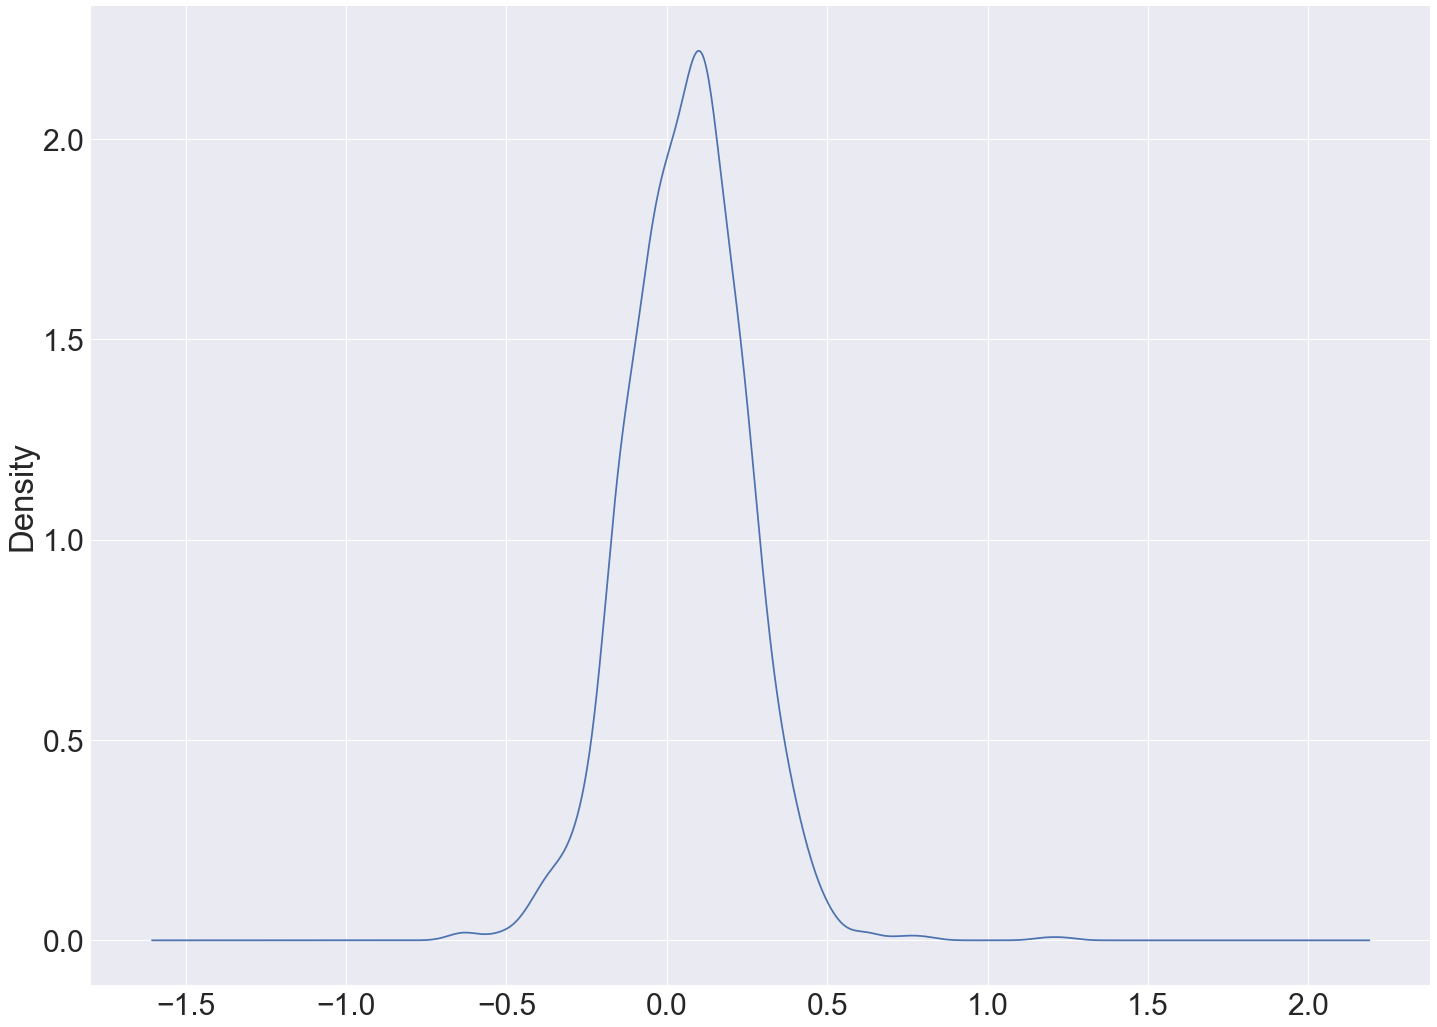

In [6]:
sp.pct_change(12).plot(kind='kde')

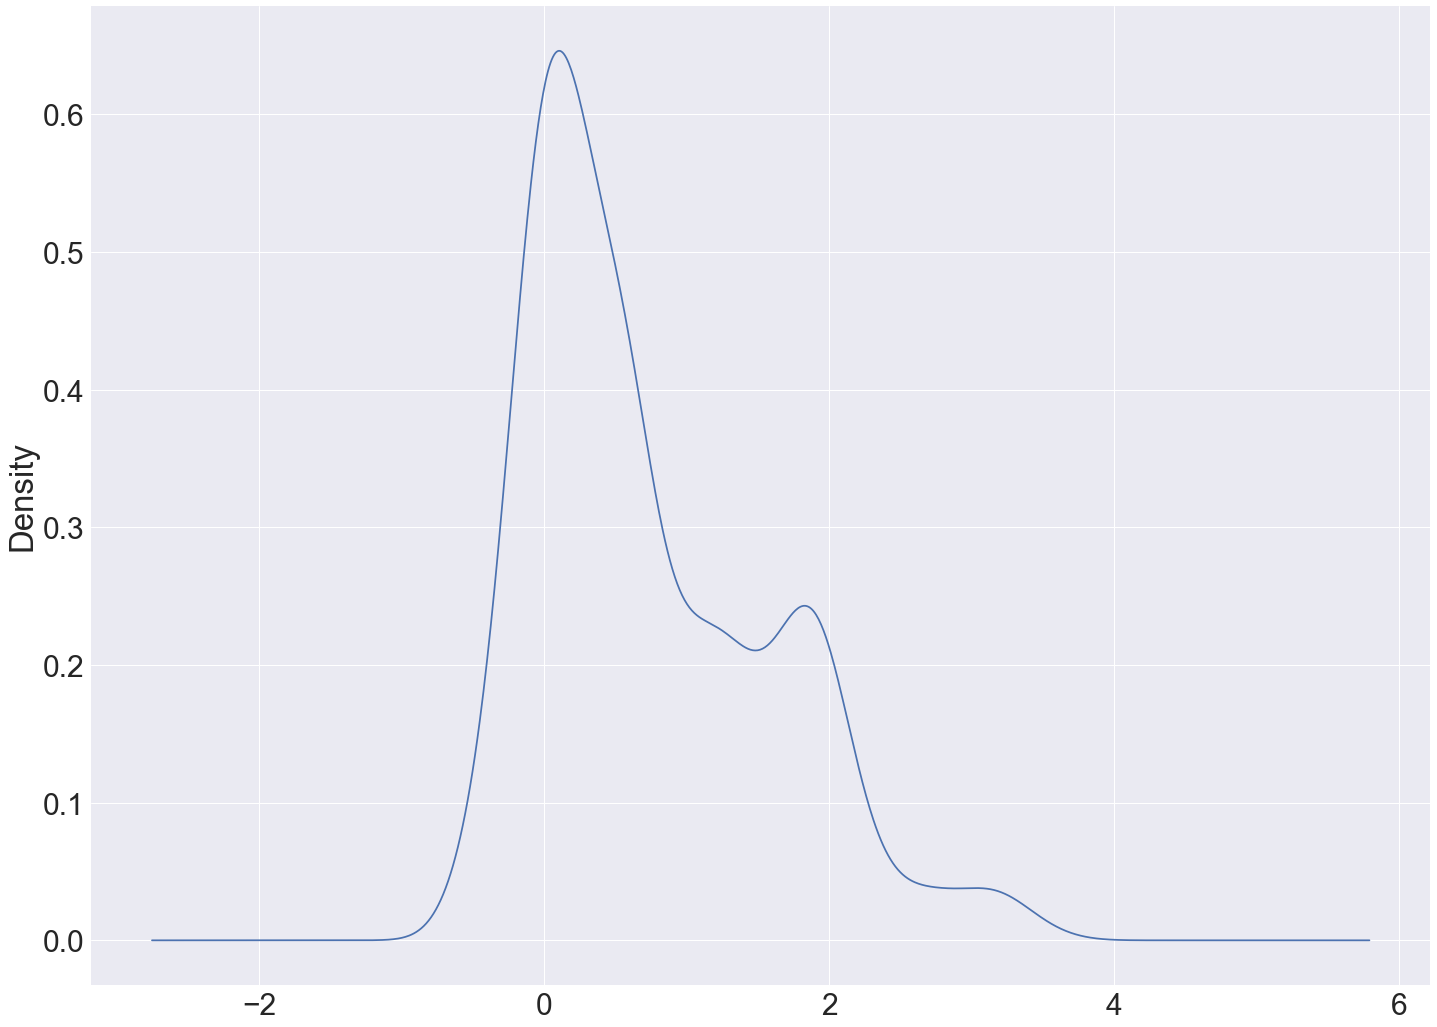

In [7]:
sp.pct_change(120).plot(kind='kde')

In [8]:
yld=q.get("FRED/DGS10", authtoken=token).Value

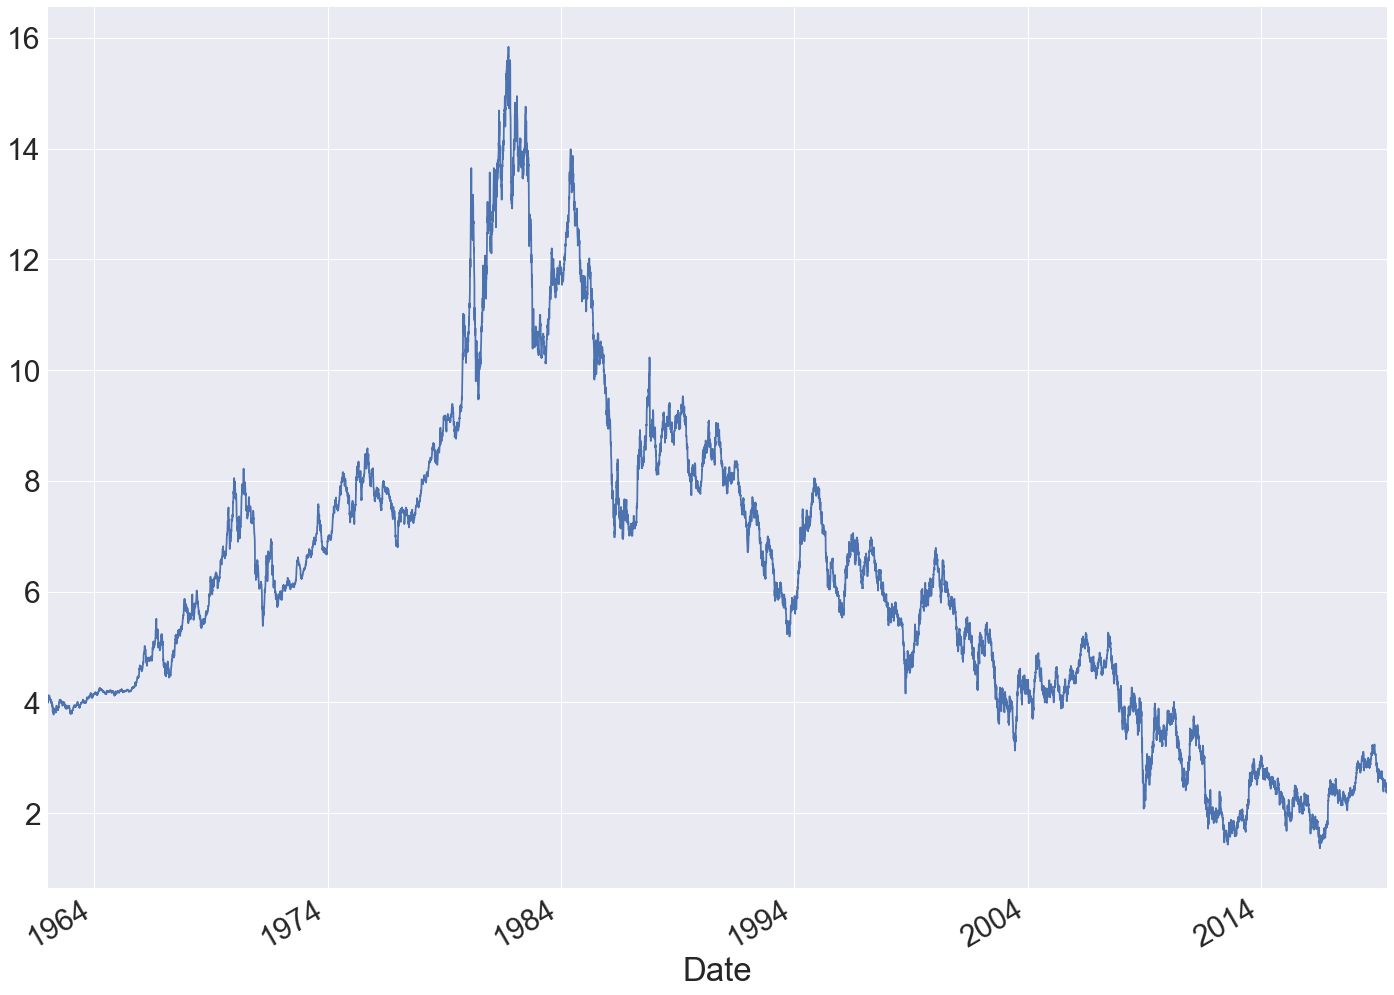

In [9]:
yld.plot()

In [10]:
def yields_to_rtn_index(yld):
    s = pd.Series()
    last=4.06
    for timestamp,yi in yld.iteritems():
        interest = yi/1200.
        np.pv(0.0403,10,4.06,fv=100)
        change=np.pv(yi/100.,10,-last,fv=-100)-100
        last=yi
        s[timestamp]=change+interest
    return s

In [11]:
bd_rtn=yields_to_rtn_index(yld.resample(rule='m').last())

In [12]:
df = pd.DataFrame()
df['SP']=sp.resample(rule='m').last().pct_change()
df['Bonds']=bd_rtn.resample(rule='m').last()/100
df=df.dropna()

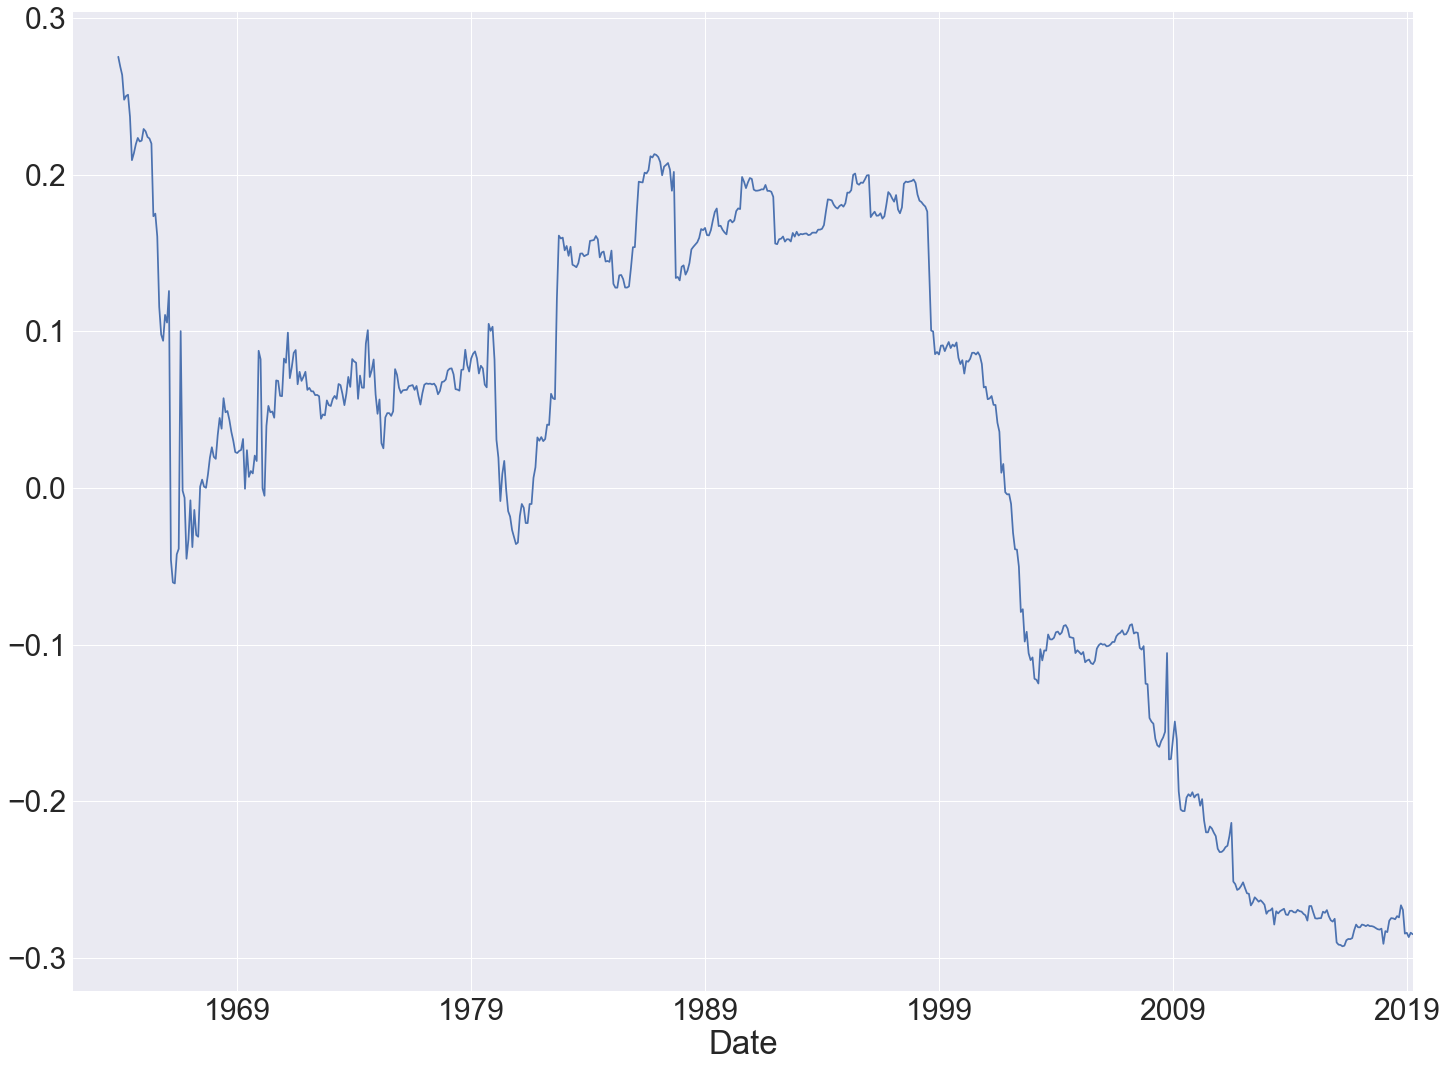

In [19]:
df.SP.ewm(120,min_periods=24).corr(df.Bonds).plot()

In [22]:
inf=q.get("RATEINF/INFLATION_USA", authtoken=token).Value

In [41]:
df2=pd.DataFrame()
df2['Stock Bond Correlation']=df.SP.rolling(120,min_periods=48).corr(df.Bonds)
df2['US Inflation']=pd.Series.rolling(inf,60).mean()

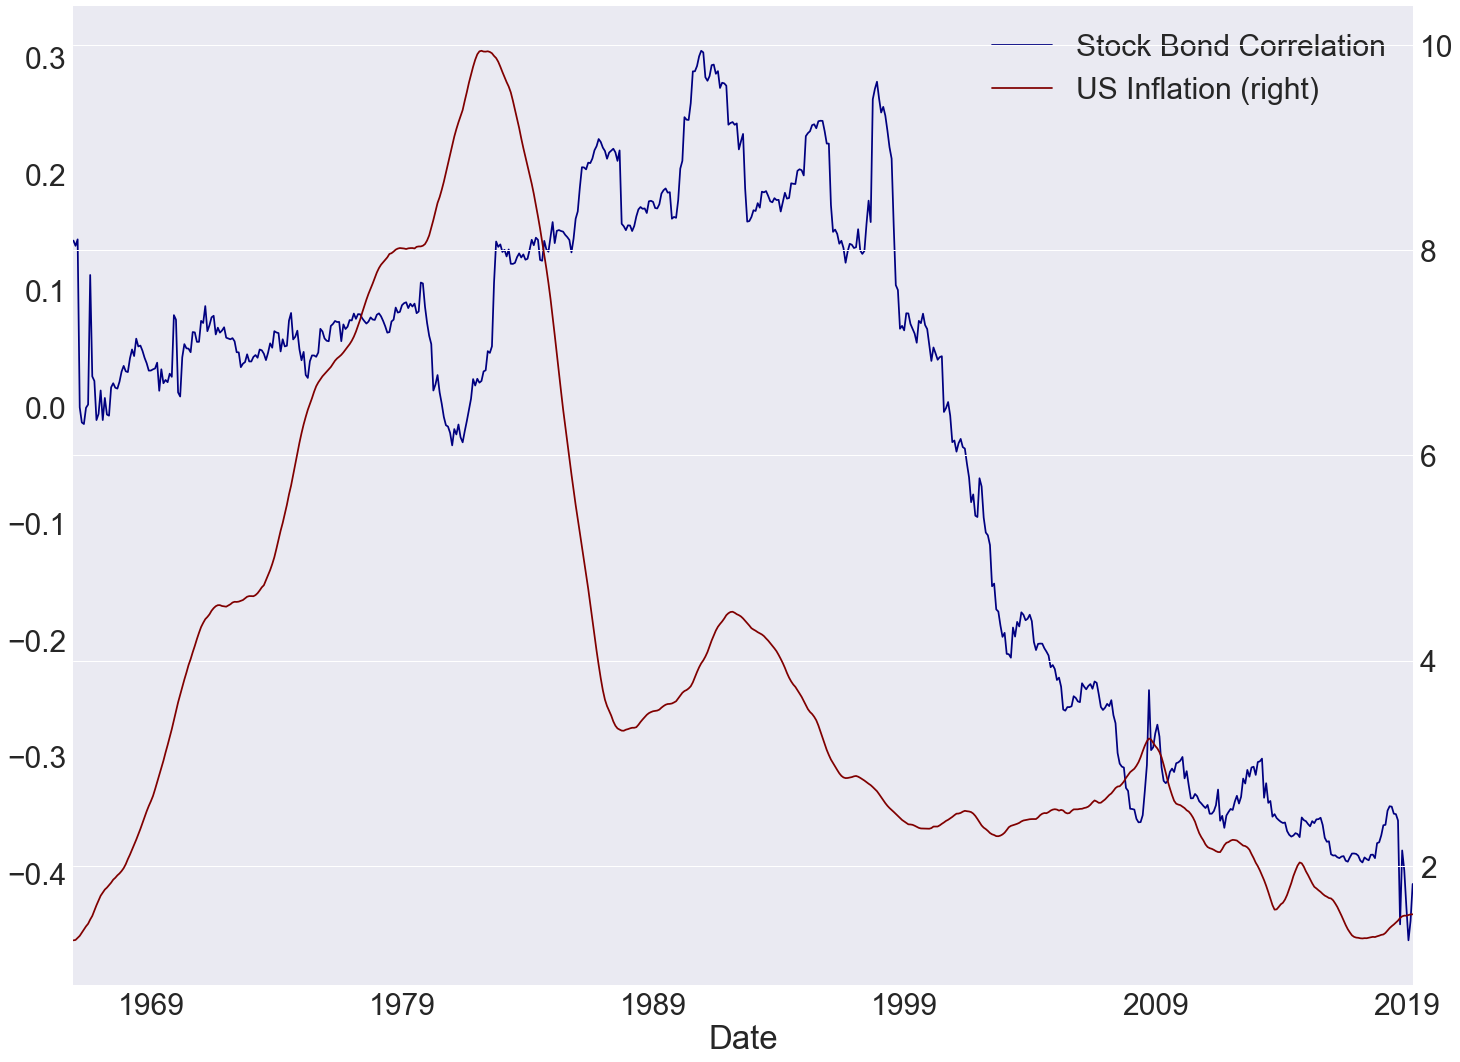

In [42]:
df2.dropna().plot(secondary_y='US Inflation',colormap='jet')